# `gitermap` examples (2)

In this notebook we will cover some more detailed examples using `scikit-learn` to iteratively fit models. Here we will use the Boston dataset and hyperparameter tune using `gitermap` to find the best $\alpha$ regularization parameter.

**Note**: For this example you will need `matplotlib`, `numpy` and `scikit-learn` installed.

In [1]:
from gitermap import MapContext

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge
from sklearn.datasets import load_boston

Load the data.

In [2]:
boston = load_boston()

In [3]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

Constructing a function that computes the test scores across multiple cross validations, for a given alpha.

In [59]:
def compute_test_score(alpha, X, y, cv):
    # preprocess X, y
    X_new = scale(X)
    return cross_val_score(Ridge(alpha), X_new, y, cv=cv, scoring="r2")

Test the example (to see it works!)

In [51]:
compute_test_score(1., boston.data, boston.target, 5)

array([ 0.64333037,  0.71683688,  0.58814318,  0.08214252, -0.22702517])

### Computing over $\alpha$ with `gitermap`.

Note that we compute once and save the result, so re-running merely loads the data in from file.

In [52]:
a_samples = np.linspace(-4., 5.5, 50)
with MapContext(verbose=1) as ctx1:
    alpha1 = ctx1.compute(compute_test_score, a_samples, X=boston.data, y=boston.target, cv=5)

100%|██████████| 50/50 [00:01<00:00, 46.34it/s]


Now for plotting the results.

Note that we concatenate the results, calculate the mean and then clip between 0 and 1 to avoid certain spurious samples which give negative $r^2$.

In [53]:
clean_alpha1 = np.vstack((alpha1))

Text(0.5, 1.0, 'Boston dataset over $\\alpha$ with $r^2 \\pm$SD')

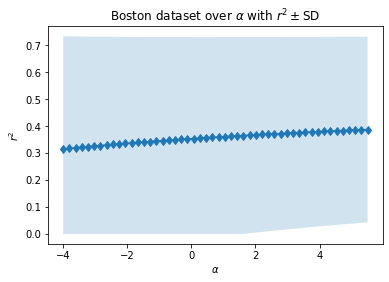

In [54]:
plt.plot(a_samples, clean_alpha1.mean(1), 'd-')
plt.fill_between(a_samples, np.clip(clean_alpha1.mean(1) + clean_alpha1.std(1), 0, 1),
                 np.clip(clean_alpha1.mean(1) - clean_alpha1.std(1), 0, 1), alpha=.2)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$r^2$")
plt.title(r"Boston dataset over $\alpha$ with $r^2 \pm$SD")

But why limit ourselves to $\alpha$? We could choose to parameterize over the cross-validation split also. To do this, we can use the `itertools.product` method to combine together `a_samples` and some cross-validation metrics.

Rather annoyingly, we must write a new function, combine together alpha and cv into a `params` argument, and then unpack them inside the custom function.

In [80]:
def compute_test_score2(params, X, y):
    # preprocess X, y
    alpha, cv = params
    X_new = scale(X)
    return cross_val_score(Ridge(alpha), X_new, y, cv=cv, scoring="r2")

In [68]:
import itertools as it

In [93]:
with MapContext(verbose=1) as ctx2:
    alpha2 = ctx1.compute(compute_test_score2, it.product(a_samples, [3, 5, 10]), X=boston.data, y=boston.target)

150it [00:03, 49.76it/s]             


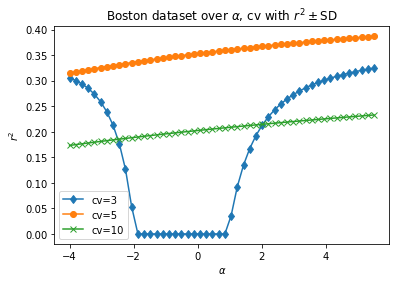

In [111]:
plt.plot(a_samples, np.clip(np.vstack(alpha2[::3]).mean(1), 0, 1), 'd-', label="cv=3")
plt.plot(a_samples, np.vstack(alpha2[1::3]).mean(1), 'o-', label="cv=5")
plt.plot(a_samples, np.vstack(alpha2[2::3]).mean(1), 'x-', label="cv=10")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$r^2$")
plt.title(r"Boston dataset over $\alpha$, cv with $r^2 \pm$SD")
plt.legend()
plt.show()

Here we see a massive variance over cross-validations: it would be better to get $K$ repeats for each cv to more properly model the variance here.

In [94]:
from sklearn.model_selection import RepeatedKFold

In [97]:
with MapContext(verbose=1) as ctx3:
    alpha3 = ctx3.compute(compute_test_score2, it.product(a_samples, [5, RepeatedKFold()]),
                          X=boston.data, y=boston.target)

100it [00:08, 11.51it/s]


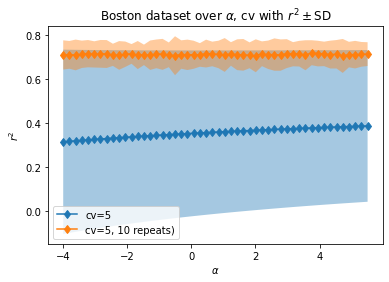

In [122]:
a31_mean = np.vstack(alpha3[::2]).mean(1)
a31_sd = np.vstack(alpha3[::2]).std(1)
a32_mean = np.vstack(alpha3[1::2]).mean(1)
a32_sd = np.vstack(alpha3[1::2]).std(1)

plt.plot(a_samples, a31_mean, 'd-', label="cv=5")
plt.fill_between(a_samples, np.clip(a31_mean + a31_sd, 0, 1),
                 a31_mean - a31_sd, alpha=.4)
plt.plot(a_samples, a32_mean, 'd-', label="cv=5, 10 repeats)")
plt.fill_between(a_samples, np.clip(a32_mean + a32_sd, 0, 1),
                 a32_mean - a32_sd, alpha=.4)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$r^2$")
plt.title(r"Boston dataset over $\alpha$, cv with $r^2 \pm$SD")
plt.legend()
plt.show()

It is clear that there was a problem with splitting the domain, giving some scores very low (in the negatives). A repeated K-fold cross-validation approach helped to resolve this, give a better accuracy and significantly smaller variance. All helped by our methodology.